# Temporal-Difference Methods

In this notebook, we will implement three Temporal-Difference (TD) learning methods(see algorithms explanation in [notebook](./temporal_difference_blackjack.ipynb)) on task `CliffWalking`. And analysis these three methods based on metrics, such as **State value plot**, **Sum of rewards during episode**

## Part 0: Explore CliffWalking Task


In [1]:
import sys
import numpy as np
import gymnasium as gym
from collections import defaultdict

import check_test
from plot_utils import plot_values, initialize_rewards_liveplot, update_rewards_liveplot

np.random.seed(42)

Use the code cell below to create an instance of the [CliffWalking](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


### **1. State**

```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
[36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```

- **Discrete State Representation**:
  - The `CliffWalking` environment's state space is a **4x12 grid**, with a total of **48 discrete states**.
  - Each state is represented as an integer, numbered from `0` to `47`, in a row-major order.
    - For example:
      - The top-left corner is state `0`.
      - The bottom-right corner is state `47`.
      - The cliff region corresponds to states `[37, 38, ..., 46]`.
	  - At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.
  - This representation is well-suited for discrete reinforcement learning algorithms like Q-learning and Sarsa.

- **Role of States**
  - The current state represents the agent's position within the grid.
  - The state changes as the agent performs actions until it reaches the goal (`G`) or falls into the cliff (`The Cliff`).


### **2. Action**

- The action space is **discrete**, consisting of 4 possible actions:
  - `0`: Move up (**UP**)
  - `1`: Move right (**RIGHT**)
  - `2`: Move down (**DOWN**)
  - `3`: Move left (**LEFT**)

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.

- **Role of Actions**
	- Each action attempts to move the agent to a neighboring cell in the corresponding direction.
	- If an action causes the agent to move out of the grid boundaries, the agent remains in its current position.

- **Execution Rules**
	- Actions are deterministic, meaning each action produces a predictable result.
	- In some extended versions (e.g., with `is_slippery=True`), actions may have stochastic outcomes.

### **3. Reward**

- Rewards are scalar values designed to guide the agent toward learning an optimal policy.
  - **Normal movement**: Performing any action (without falling into the cliff) gives a reward of **-1**.
  - **Falling into the cliff**: If the agent moves into the cliff region (`The Cliff`), it receives a reward of **-100** and is reset to the starting position (`S`).
  - **Reaching the goal**: Reaching the goal (`G`) ends the episode but provides no additional reward.

- **Role of Rewards**
	- The reward function encourages the agent to find a path that is both fast and avoids falling into the cliff.
	- The large penalty for falling into the cliff (-100) forces the agent to balance **path length** and **safety**.

### **4. Summary**
| **Element** | **Description** |
|-------------|------------------------------------------------------------------------|
| **State**   | Discrete 4x12 grid with 48 states, represented as integers (0 to 47). |
| **Action**  | 4 discrete actions: `0` (up), `1` (right), `2` (down), `3` (left). |
| **Reward**  | -1 (normal movement), -100 (falling into the cliff), no extra reward for reaching the goal. |
| **Start**   | Bottom-left corner (state `36`). |
| **Goal**    | Bottom-right corner (state `47`). |
| **Cliff**   | Bottom row cells `[37, 38, ..., 46]`. Falling here and resets the agent to the starting position. |

### 5.Optimal State Value Function

In theory, we have below's equation to calculate optimal state value function

$$
\begin{aligned}
v_\pi(s) &= \mathbb{E}_\pi \left[ G_t \,\middle|\, S_t = s \right] \\
G_t &= R_{t+1} + \gamma G_{t+1} \\
v_\pi(s) &= \mathbb{E}_\pi \left[ R_{t+1} + \gamma G_{t+1} \,\middle|\, S_t = s \right] \\
         &= \mathbb{E}_\pi \left[ R_{t+1} \,\middle|\, S_t = s \right] + \gamma \, \mathbb{E}_\pi \left[ G_{t+1} \,\middle|\, S_t = s \right] \\
         &= \sum_{a \in \mathcal{A}} \pi(a \,|\, s) \sum_{s' \in \mathcal{S}} \mathcal{P}(s' \,|\, s, a) \left[ R(s, a, s') + \gamma v_\pi(s') \right],
\end{aligned}
$$

Since $a \leftarrow \pi(s)$ is determinstic and state transition $\mathcal{P}(s' \,|\, s, a)$  is determinstic, so in this problem, we have:
$$
v_\pi(s) =  R(s, a, s') + \gamma v_\pi(s')
$$

where `T` is terminal state, we already have $v_\pi(T) = 0$, based above recurrsive equation, we can calculate `V_opt`


_**Note**: we ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

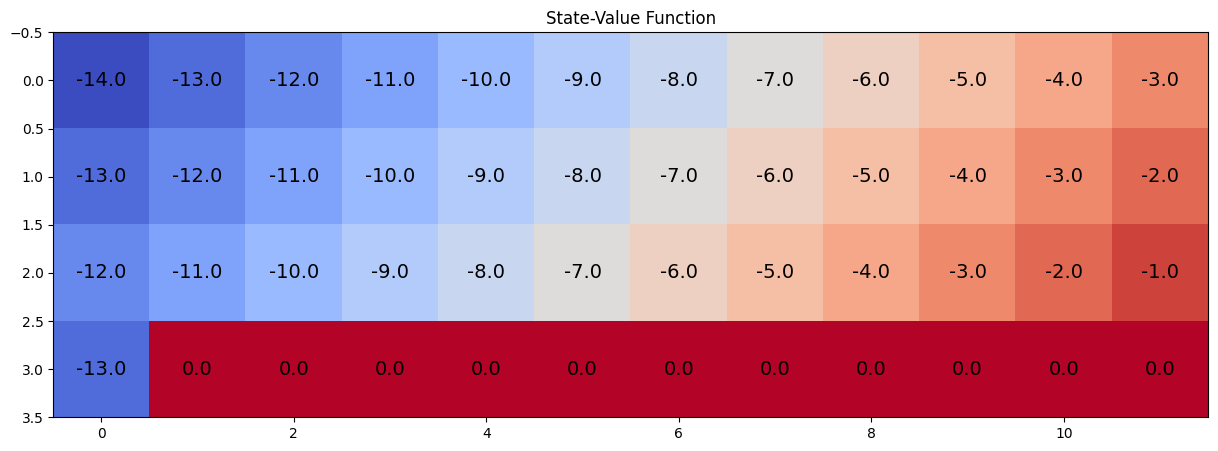

In [3]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

## Part 1: TD Control: Sarsa

Algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym(maintained by [Gymnasium](https://github.com/Farama-Foundation/Gymnasium)) environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

> note: we refer $R_{t}$ as $R_{t+1}$ current reward based $S_t$ and $A_t$, just for name convention, so slightly different with below's define.


![](./images/td-learning-sarsa-psedocode.png)

In [4]:
def epsilon_greedy(actions, epsilon):
    nA = len(actions)
    if np.random.random() > epsilon:
        return np.argmax(actions)
    else:
        return np.random.choice(np.arange(nA))

In [9]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize action-value function (empty dictionary of arrays)
    
    Q = defaultdict(lambda: np.zeros(nA))
    
    # initialize epsilon for future decay
    epsilon = 1.0

    # Store every episode's total reward
    episode_rewards = []
    episodes = []

    # initial live plot of total rewards
    fig = initialize_rewards_liveplot(name="Sarsa")
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        epsilon = epsilon / i_episode

        # observe S_0
        state, info = env.reset()
        
        # choose action A_0 using policy derived from Q table
        action = epsilon_greedy(Q[state], epsilon)

        # record current episode total reward
        episode_reward = 0

        # in a episode
        while True:

            # take action A_t and observe R_t, S_t+1
            next_state, reward, done, truncated, info = env.step(action)

            # culmulative reward
            episode_reward += reward
            
            # until S_t is terminal and exit this episode
            if done:
                Q[state][action] = Q[state][action] + alpha * (reward - Q[state][action])
                break

            # choose action A_t+1 using same policy derived from Q table
            next_action = epsilon_greedy(Q[next_state], epsilon)
            
            # update Q table
            G_estimate = reward + gamma * Q[next_state][next_action]
            Q[state][action] = Q[state][action] + alpha * (G_estimate - Q[state][action])

            state, action = next_state, next_action
        
        episode_rewards.append(episode_reward)
        episodes.append(i_episode)
        
        # update live plot of total rewards
        if i_episode % 100 == 0:
            update_rewards_liveplot(fig, episodes, episode_rewards)

    return Q, episode_rewards

visualize the **_estimated_** optimal policy and the corresponding state-value function.

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  1  1  1  2  0  1  1  1  2]
 [ 3  2  1  2  2  3  1  3  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


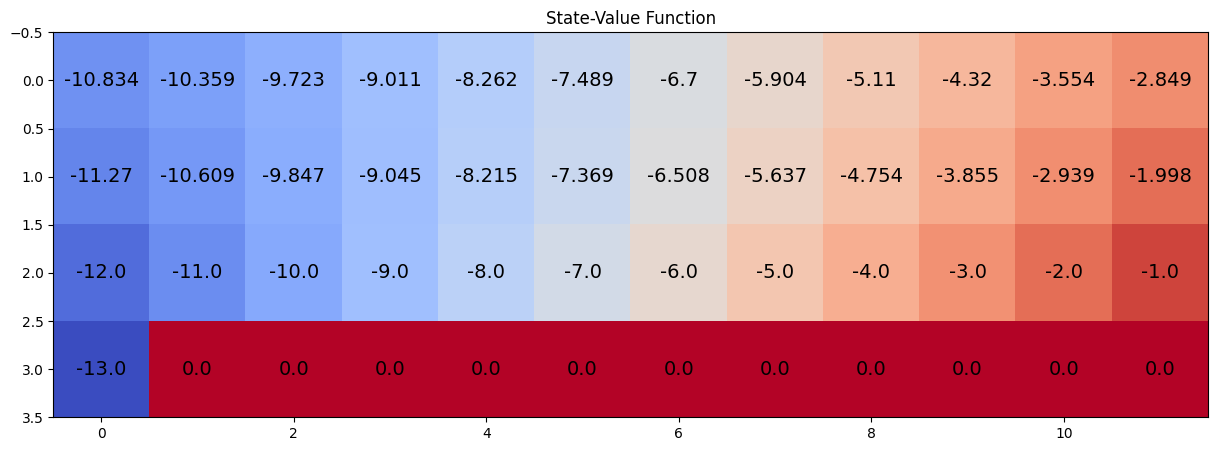

In [11]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa, sarsa_rewards = sarsa(env, 5000, 0.01)

# print the estimated optimal policy
policy_sarsa = np.array(
    [np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]
).reshape(4, 12)

check_test.run_check("td_control_check", policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = [np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)]
plot_values(V_sarsa)

## Part 2: TD Control: Q-learning

Algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

> note: we refer $R_{t}$ as $R_{t+1}$ current reward based $S_t$ and $A_t$, just for name convention, so slightly different with below's define.

![](./images/sarsamax-or-q-learning-psedocode.png)

In [12]:
def q_learning(env, num_episodes, alpha, gamma=1.0):

    nA = env.action_space.n

    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))

    # initialize epsilon for future decay
    epsilon = 1.0

    # Store every episode's total reward
    episode_rewards = []
    episodes = []

    # initial live plot of total rewards
    fig = initialize_rewards_liveplot(name="Q-learning")

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        epsilon = epsilon / i_episode

        # observe S_0
        state, info = env.reset()
        
        # record current episode total reward
        episode_reward = 0

        # in a episode
        while True:

            # choose action A_t using policy derived from Q table
            action = epsilon_greedy(Q[state], epsilon)

            # take action A_t and observe R_t, S_t+1
            next_state, reward, done, truncated, info = env.step(action)

            # culmulative reward
            episode_reward += reward
            
            # until S_t is terminal and exit this episode
            if done:
                Q[state][action] = Q[state][action] + alpha * (reward - Q[state][action])
                break
            
            # update Q table
            G_estimate = reward + gamma * np.max(Q[next_state])
            Q[state][action] = Q[state][action] + alpha * (G_estimate - Q[state][action])

            state = next_state
        
        episode_rewards.append(episode_reward)
        episodes.append(i_episode)
        
        # update live plot of total rewards
        if i_episode % 100 == 0:
            update_rewards_liveplot(fig, episodes, episode_rewards)
        
    return Q, episode_rewards

visualize the **_estimated_** optimal policy and the corresponding state-value function. 

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  0  1  1  1  1  1  0  1  1  2]
 [ 3  1  1  3  1  1  1  1  2  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


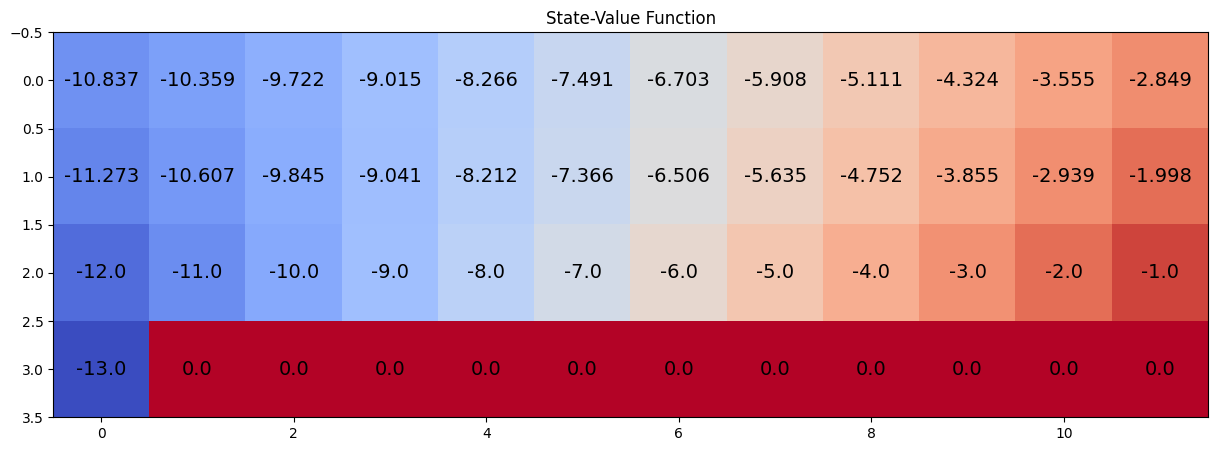

In [13]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax, sarsamax_rewards = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

## Part 3: TD Control: Expected Sarsa

Algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

> note: we refer $R_{t}$ as $R_{t+1}$ current reward based $S_t$ and $A_t$, just for name convention, so slightly different with below's define.

![](./images/expected-sarsa-psedocode.png)

In [17]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):

    nA = env.action_space.n

    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))

    # initialize epsilon for future decay
    epsilon = 1.0

    # Store every episode's total reward
    episode_rewards = []
    episodes = []

    # initial live plot of total rewards
    fig = initialize_rewards_liveplot(name="Expected Sarsa")

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        epsilon = 0.005

        # observe S_0
        state, info = env.reset()
        
        # record current episode total reward
        episode_reward = 0

        # in a episode
        while True:

            # choose action A_t using policy derived from Q table
            action = epsilon_greedy(Q[state], epsilon)

            # take action A_t and observe R_t, S_t+1
            next_state, reward, done, truncated, info = env.step(action)

            # culmulative reward
            episode_reward += reward
            
            # until S_t is terminal and exit this episode
            if done:
                Q[state][action] = Q[state][action] + alpha * (reward - Q[state][action])
                break
            
            # update Q table
            next_probs = np.ones(nA) * (epsilon / nA)
            next_probs[np.argmax(Q[next_state])] = 1 - epsilon + (epsilon / nA)
            expection = np.dot(next_probs, Q[next_state])
            
            G_estimate = reward + gamma * expection
            Q[state][action] = Q[state][action] + alpha * (G_estimate - Q[state][action])

            state = next_state
        
        episode_rewards.append(episode_reward)
        episodes.append(i_episode)
        
        # update live plot of total rewards
        if i_episode % 100 == 0:
            update_rewards_liveplot(fig, episodes, episode_rewards)
        
    return Q, episode_rewards

visualize the **_estimated_** optimal policy and the corresponding state-value function.  

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  1  0  1  3  0  2  2  1  1  2]
 [ 1  0  0  1  1  1  1  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


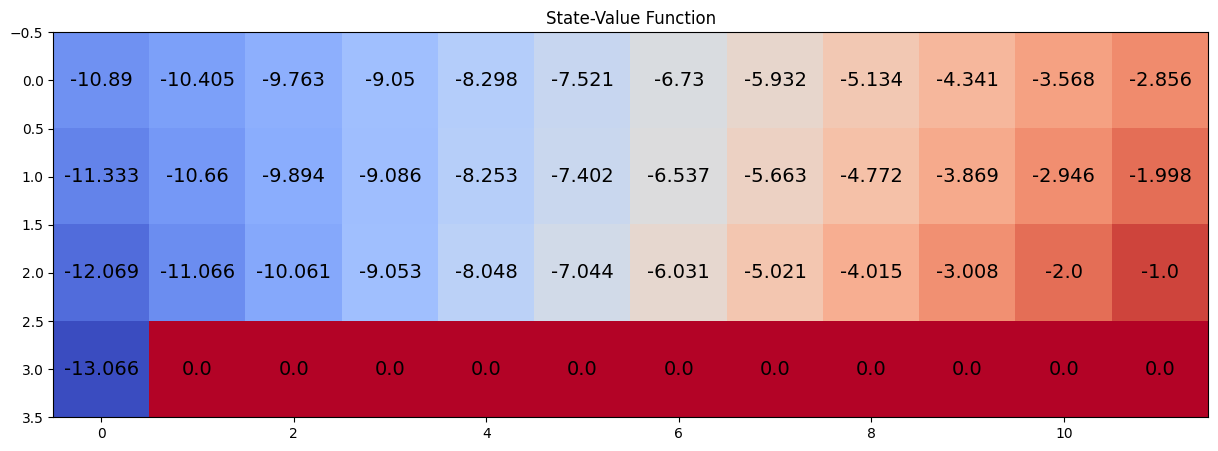

In [21]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa, expsarsa_rewards = expected_sarsa(env, 5000, 0.01)

# print the estimated optimal policy
policy_expsarsa = np.array(
    [np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]
).reshape(4, 12)
check_test.run_check("td_control_check", policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values(
    [np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)]
)

## Disscussion

In [26]:
import plotly.graph_objects as go

def plot_learning_curves(sarsa_rewards, sarsamax_rewards, expected_sarsa,
                         num_episodes):
    """
    Plot SARSA and Q-Learning learning curves。
    """
    episodes = list(range(1, num_episodes + 1))
    
    fig = go.Figure()
    
    fig.add_trace(
        go.Scatter(
            x=episodes,
            y=sarsa_rewards,
            mode='lines',
            name='SARSA',
            line=dict(color='blue')
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=episodes,
            y=sarsamax_rewards,
            mode='lines',
            name='Q-Learning',
            line=dict(color='green')
        )
    )

    fig.add_trace(
        go.Scatter(
            x=episodes,
            y=expected_sarsa,
            mode='lines',
            name='Expected SARSA',
            line=dict(color='grey')
        )
    )
    
    fig.update_layout(
        title='Learning Curves: SARSA vs Q-Learning vs Expected SARSA',
        xaxis_title='Episodes',
        yaxis_title='Sum of rewards during episode',
        yaxis=dict(range=[-100, 0]), 
        showlegend=True
    )
    
    fig.show()

num_episodes = 5000

plot_learning_curves(sarsa_rewards, sarsamax_rewards, expsarsa_rewards, num_episodes)
